show fct

In [2]:
C = [
    'xkcd:grass green',
    'xkcd:blue',
    'xkcd:purple',
    'xkcd:orange',
    'xkcd:teal',
    'xkcd:brick red',
    'xkcd:black',
    'xkcd:brown',
    'xkcd:grey',
]

LS = [
    'solid',
    'dashed',
    'dotted',
    'dashdot'
]



import subprocess

def get_pctl(a, p):
	i = int(len(a) * p)
	return a[i]

def size2str(steps):
    result = []
    for step in steps:
        if step < 10000:
            result.append("{:.1f}K".format(step / 1000))
        elif step < 1000000:
            result.append("{:.0f}K".format(step / 1000))
        else:
            result.append("{:.1f}M".format(step / 1000000))

    return result

def get_steps_from_raw(id, step=5):
    filename = f"../mix/output/{id}/{id}_out_fct.txt"
    time_start = int(2.000 * 1000000000)
    time_end = int(3.0 * 1000000000) 
    cmd_slowdown = "cat %s"%(filename)+" | awk '{ if ($6>"+"%d"%time_start+" && $6+$7<"+"%d"%(time_end)+") { slow=$7/$8; print slow<1?1:slow, $5} }' | sort -n -k 2"    
    output_slowdown = subprocess.check_output(cmd_slowdown, shell=True)
    aa = output_slowdown.decode("utf-8").split('\n')[:-2]
    nn = len(aa)

    # CDF of FCT
    res = [[i/100.] for i in range(0, 100, step)]
    for i in range(0,100,step):
        l = int(i * nn / 100)
        r = int((i+step) * nn / 100)
        fct_size = aa[l:r]
        fct_size = [[float(x.split(" ")[0]), int(x.split(" ")[1])] for x in fct_size]
        fct = sorted(map(lambda x: x[0], fct_size))
        
        res[int(i/step)].append(fct_size[-1][1]) # flow size
        
        res[int(i/step)].append(sum(fct) / len(fct)) # avg fct
        res[int(i/step)].append(get_pctl(fct, 0.5)) # mid fct
        res[int(i/step)].append(get_pctl(fct, 0.95)) # 95-pct fct
        res[int(i/step)].append(get_pctl(fct, 0.99)) # 99-pct fct
        res[int(i/step)].append(get_pctl(fct, 0.999)) # 99-pct fct
    

    result = {"avg": [], "p99": [], "size": []}
    for item in res:
        if item[1] / (10 ** 3) <= 400:
            result["avg"].append(item[2])
            result["p99"].append(item[5])
            result["size"].append(item[1] / (10 ** 3))

    return result
    

bandwidth

In [3]:
def get_bandwidth_info(id, type):
    if (type == 0):
        type_str = "out_uplink"
    elif (type == 1):
        type_str = "out_downlink"
    elif (type == 2):
        type_str = "out_uplink_rx"
    elif (type == 3):
        type_str = "out_downlink_rx"
    file_path = f"../mix/output/{id}/{id}_{type_str}.txt"
    time_list = []
    info_list = []
    total_list = []
    bytes_current = {}
    current_time = 2000000000 - 1
    with open(file_path, 'r') as file:
        for line in file:
            numbers = list(map(int, line.split(",")))
            link = (min(numbers[1], numbers[2]), max(numbers[1], numbers[2]))
            time = numbers[0]
            if current_time != time:
                time_list.append(time - 2000000000)
                info_list.append({})
                current_time = time
            if link in bytes_current:
                rates = (numbers[3] - bytes_current[link]) * 8 / (0.00001 * 1000 * 1000 * 1000)
                info_list[-1][link] = rates
                bytes_current[link] = numbers[3]
            else:
                bytes_current[link] = numbers[3]
                rates = (numbers[3]) * 8 / (0.00001 * 1000 * 1000 * 1000)
                info_list[-1][link] = rates
    for i in range(len(info_list)):
        rates = 0
        total_band = 0
        for link in info_list[i]:
            rates += info_list[i][link]
            total_band += 100
        if rates / total_band > 1:
            total_list.append(1)
        else:
            total_list.append(rates / total_band)
    return time_list, total_list

simulate_id for each method

In [4]:
fecmp_id = 206867519
CAVER_id = 33153082
conweave_id = 852410278

FCT显示

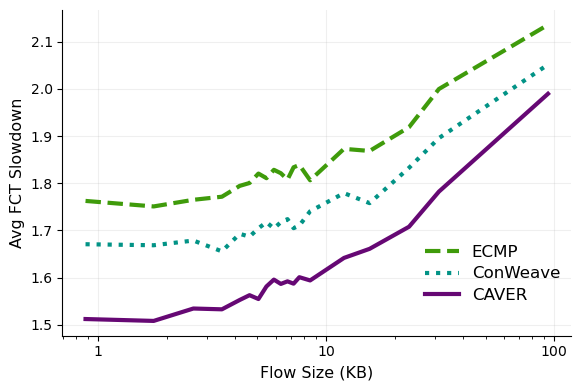

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('plot.pdf')
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
STEP = 5
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Flow Size (KB)", fontsize=11.5)
ax.set_ylabel("Avg FCT Slowdown", fontsize=11.5)

xvals = [i for i in range(STEP, 100 + STEP, STEP)]

lb_mode = "ECMP"
ecmp_result = get_steps_from_raw(fecmp_id, STEP)
# ax.plot(xvals, result["avg"], markersize=1.0, linewidth=3.0, label="{}".format(lb_mode), linestyle=LS[1])
ax.plot(ecmp_result["size"], ecmp_result["avg"], markersize=1.0, linewidth=3.0, label="{}".format(lb_mode), linestyle=LS[1], color = 'xkcd:grass green')

# lb_mode = "conga"
# result = get_steps_from_raw(conga_id, STEP)
# # ax.plot(xvals, result["avg"], markersize=1.0, linewidth=3.0, label="{}".format(lb_mode), linestyle=LS[1])
# ax.plot(result["size"], result["avg"], markersize=1.0, linewidth=3.0, label="{}".format(lb_mode), linestyle=LS[1], color = 'xkcd:orange')

lb_mode = "ConWeave"
conweave_result = get_steps_from_raw(conweave_id, STEP)
ax.plot(conweave_result["size"], conweave_result["avg"], markersize=1.0, linewidth=3.0, label="{}".format(lb_mode), linestyle=LS[2], color = 'xkcd:teal')

lb_mode = "CAVER"
caver_result = get_steps_from_raw(CAVER_id, STEP)
ax.plot(caver_result["size"], caver_result["avg"], markersize=1.0, linewidth=3.0, label="{}".format(lb_mode), linestyle=LS[0], color=(102 / 255, 8 / 255, 116 / 255))

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

# 0.0,1.2
ax.legend(bbox_to_anchor=(0.7, 0.3), loc="upper left", borderaxespad=0,
        frameon=False, fontsize=12, facecolor='white', ncol=1,
        labelspacing=0.4, columnspacing=0.8)

ax.set_xscale('log')
log_ticks = np.log10([1, 10, 10 ** 2])  # 将线性值转换为对数值
ax.set_xticks(10 ** log_ticks)
ax.set_xticklabels([r"$1$", r"$10$", r"$100$"])


ax.grid(True, which='major')

# 关闭次要刻度线
ax.grid(False, which='minor')

# 显示网格线的透明度
ax.grid(True, which='major', alpha=0.2)
# ax.set_ylim(1.4, 2.2)
plt.tight_layout() 
pdf.savefig() 
pdf.close()
plt.show()

In [6]:
min_ecmp = 1
min_conweave = 1
for i in range(len(ecmp_result["size"])):
    if caver_result["avg"][i] / ecmp_result["avg"][i] < min_ecmp:
        min_ecmp = caver_result["avg"][i] / ecmp_result["avg"][i]
    if caver_result["avg"][i] / conweave_result["avg"][i] < min_conweave:
        min_conweave = caver_result["avg"][i] / conweave_result["avg"][i]
    # print("{}\t{}\t{}\t{}".format(ecmp_result["size"][i], ecmp_result["avg"][i], conweave_result["avg"][i], caver_result["avg"][i]))
print(min_ecmp)
print(min_conweave)

0.8540753257940302
0.9039809331452326


In [7]:
bond_id = 814285641
no_bond_id = 757479882

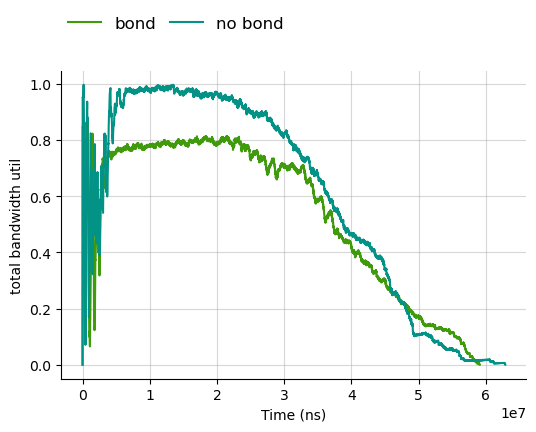

In [8]:
bond_uplink_tx_time_list,  bond_uplink_tx_total_list= get_bandwidth_info(bond_id, 0)
no_bond_uplink_tx_time_list,  no_bond_uplink_tx_total_list= get_bandwidth_info(no_bond_id, 0)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(bond_uplink_tx_time_list, bond_uplink_tx_total_list, label="bond", color='xkcd:grass green')
ax.plot(no_bond_uplink_tx_time_list, no_bond_uplink_tx_total_list, label="no bond", color='xkcd:teal')


# Adding labels and legend
plt.xlabel("Time (ns)")
plt.ylabel("total bandwidth util")
plt.legend()
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


ax.legend(bbox_to_anchor=(0.0, 1.2), loc="upper left", borderaxespad=0,
        frameon=False, fontsize=12, facecolor='white', ncol=3,
        labelspacing=0.4, columnspacing=0.8)
ax.grid(True, which='minor', alpha=0.2)
# Display the plot
plt.show()
